In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re

# Loading data

Data can be downloaded as a `zip` file at https://drive.google.com/file/d/1h0ThrK252cyeJr4TwkqQCNKJhGMji-4B/view?usp=sharing

It contains the following files:

- `newspapers.jsonl` 190MB, 100 000 articles
- `newspapers_sample.jsonl` 200KB, 100 articles

Extract them to the project's root directory.

JSONL is a file format that contains a sequence of JSON objects, each object in a separate line.


In [2]:
from json import loads, dumps

data_sample = [
    loads(line)
    for line in open("data/newspapers_sample.jsonl", "r", encoding="utf-8").readlines()
]

data = [
    loads(line)
    for line in open("data/newspapers.jsonl", "r", encoding="utf-8").readlines()
]

data_sample[:3]

[{'text': 'On ne s’attendait pas du tout à trouver une ville aussi jolie entourée de remparts. » La surprise émerveille plus d’un touriste, qu’il soit français ou étranger, quand il découvre Angoulême. Le Plateau et ses ruelles surprennent. Et surtout séduisent. Notamment les étrangers dont on fête le grand retour, cette année, après deux étés de disette en raison de la crise sanitaire.\n\nBelges, Britanniques et Néerlandais constituent le hit de parade des nationalités représentées depuis début juillet. On croise également des Espagnols, des Italiens et quelques Nord-Américains. Et même des Danois, accueillis pour la première fois au Musée d’art et d’histoire de la ville. « Peut-être grâce au Tour de France ! », avance-t-on dans un sourire à l’accueil.\n\nLes Anglo-Saxons et les vieilles pierres\n\nDifficile de dire si le label « Ville créative », délivré par l’Unesco fin 2019, pèse sur la venue d’étrangers dans la ville. Peu semblent au courant de cette reconnaissance. S’ils s’arrête

### Fields

What are the fields of the JSON objects?


In [3]:
keys = {key for item in data for key in item.keys()}
keys

{'article', 'date', 'text', 'title'}

### Transform the json objects in dataframes


In [4]:
df = pd.DataFrame(data)
df_sample = pd.DataFrame(data_sample)

### Any missing values? (No)


In [5]:
df.isnull().sum()

text       0
title      0
date       0
article    0
dtype: int64

# Lengths of titles and texts


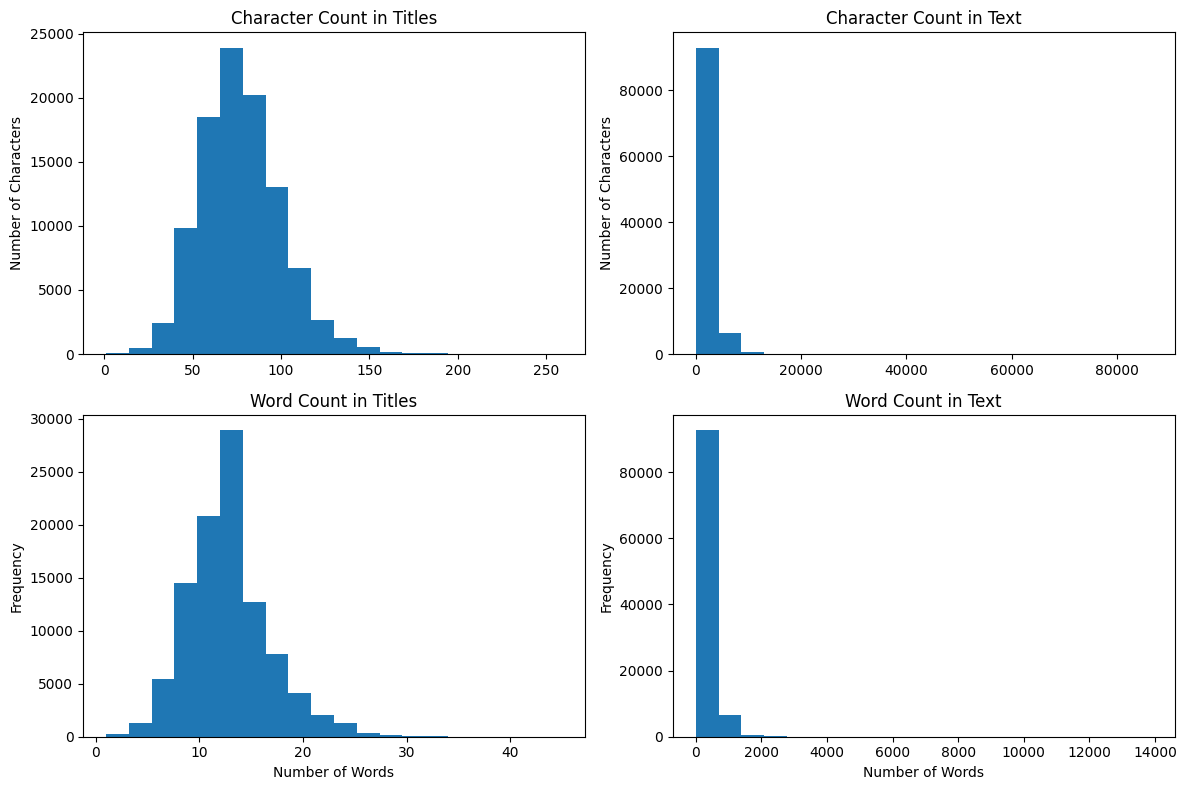

In [6]:
# Calculate the number of characters in titles and text
df["title_char_count"] = df["title"].str.len()
df["text_char_count"] = df["text"].str.len()

# Calculate the number of words in titles and text
df["title_word_count"] = df["title"].str.split().str.len()
df["text_word_count"] = df["text"].str.split().str.len()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot of character count in titles
axs[0, 0].hist(df["title_char_count"], bins=20)
axs[0, 0].set_title("Character Count in Titles")
axs[0, 0].set_ylabel("Number of Characters")

# Boxplot of character count in text
axs[0, 1].hist(df["text_char_count"], bins=20)
axs[0, 1].set_title("Character Count in Text")
axs[0, 1].set_ylabel("Number of Characters")

# Histogram of word count in titles
axs[1, 0].hist(df["title_word_count"], bins=20)
axs[1, 0].set_title("Word Count in Titles")
axs[1, 0].set_xlabel("Number of Words")
axs[1, 0].set_ylabel("Frequency")

# Histogram of word count in text
axs[1, 1].hist(df["text_word_count"], bins=20)
axs[1, 1].set_title("Word Count in Text")
axs[1, 1].set_xlabel("Number of Words")
axs[1, 1].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [7]:
# Show the longuest titles
longuest_titles = df.sort_values("title_char_count", ascending=False).head(200)

longuest_titles[["title", "title_char_count"]]

,title,title_char_count
42978,L'essentiel du sport dans nos régions. Antoine...,259
48421,En image | ddddddddddddddddddddddddddddddddddd...,249
28621,"La Suédoise Linn Grant regarde son drive, au d...",248
91553,La Matinale. Pierre Palmade gravement blessé d...,245
27317,L'essentiel du sport dans nos régions. Premier...,238
...,...,...
99320,Des naturalistes d'Alsace Bossue mobilisés con...,165
11647,Mâcon (communiqué ). La commission des finance...,165
77353,"Disparition d'Alex Batty : ""Il nous accompagna...",165
16987,Un 47eme fourgon d'intervention percuté sur l'...,165


### Repeating characters


- We found the text `dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddeeeeeeeeeeeeeeeeeeeePose`in a title.
  It might be useful to count the number of repeating characters in the text.


In [8]:
def count_repeating_chars(text: str) -> int:
    """Count the number of repeating characters in a string.

    Example:
    count_repeating_chars('aab') -> 1
    count_repeating_chars('aaabb') -> 3
    """
    count = 0
    for i in range(1, len(text)):
        if text[i] == text[i - 1]:
            count += 1
    return count


assert count_repeating_chars("aab") == 1
assert count_repeating_chars("aaabb") == 3

In [9]:
def count_repeating_non_whitespace_chars(text: str) -> int:
    """Count the number of repeating non-whitespace characters in a string.

    Example:
    count_repeating_non_whitespace_chars('aab') -> 1
    count_repeating_non_whitespace_chars('aaabb') -> 3
    count_repeating_non_whitespace_chars('aa a') -> 2
    """
    text = text.replace(" ", "").replace("\n", "").replace("\t", "").replace("\r", "")
    return count_repeating_chars(text)


assert count_repeating_non_whitespace_chars("aab") == 1
assert count_repeating_non_whitespace_chars("aaabb") == 3
assert count_repeating_non_whitespace_chars("aa a") == 2

Only counting the number of repeating characters in the text would penalize long texts. We should normalize this number by the length of the text.


In [10]:
# Count repeating characters in titles and text and dividing by the number of characters

df["title_repeating_chars"] = (
    df["title"].apply(count_repeating_non_whitespace_chars) / df["title_char_count"]
)
df["text_repeating_chars"] = (
    df["text"].apply(count_repeating_non_whitespace_chars) / df["text_char_count"]
)

In [11]:
# Show the rows with the highest ratio of repeating characters in titles
df.sort_values("title_repeating_chars", ascending=False).head(10)[
    ["title", "title_repeating_chars"]
]

,title,title_repeating_chars
48421,En image | ddddddddddddddddddddddddddddddddddd...,0.510040
34828,ZOOM,0.250000
16286,495 000 €,0.222222
9521,XXXXXXXXX. Une législation qui évolue en perma...,0.176471
22558,500 à sillonner le terroir,0.153846
73655,Comment placer 50 000 euros,0.148148
82484,Halloween en familles,0.142857
12681,Football. ASSE : le successeur de Laurent Batl...,0.121212
63319,On a testé...l'attelage !,0.120000
52597,Un football lorrain au fort accent polonais,0.116279


In [12]:
# Same for text
df.sort_values("text_repeating_chars", ascending=False).head(10)[
    ["title", "text", "text_repeating_chars"]
]

,title,text,text_repeating_chars
48421,En image | ddddddddddddddddddddddddddddddddddd...,En image | ddddddddddddddddddddddddddddddddddd...,0.414791
56337,Confolens : Le prix Abel Desaphy disputé jeudi,"Pour les épreuves d’école de vélo, les dossard...",0.314079
92943,Football : découvrez les affiches du 5e tour d...,????? ?? ?????? : ???????? ?? ?? ???? \ud83c\u...,0.235808
26287,Aveyron : suivez le week-end de sports en direct,"Football, basket-ball, handball, moto ou encor...",0.205108
73389,"Football, basket-ball, handball : suivez les r...",Suivez ci-dessous l'avancée des résultats spor...,0.175405
27180,"Football, handball, trail : retrouvez tous les...",Retrouvez ci-dessous l'ensemble des résultats ...,0.135633
95416,"Rugby, football, basket-ball : suivez en direc...","Football, rugby à XIII et à XV, handball, bask...",0.119357
64024,"Football, auto, basket-ball : suivez en direct...","Football, rugby à XIII, handball, automobile.....",0.101159
55529,"Basket-ball, rugby, football : découvrez tous ...","Basket-ball, football, handball, rugby....Retr...",0.100370
81783,"Football, basket-ball, rugby : le Sporting dec...","Football, rugby à XIII et à XV, handball, cour...",0.093532


Turns out the only problematic text is the one mentioned above.


In [13]:
# Drops rows having a title with more than 0.50 repeating characters score
df = df[df["title_repeating_chars"] < 0.50]

### Looking at the shortests titles


In [14]:
df.sort_values("title_char_count").head(10)[["title", "title_char_count", "text"]]

,title,title_char_count,text
59191,8,1,"...pour lire la suite, rejoignez notre communa..."
85033,164,3,"164\n\nC’est en millions d’euros, la somme des..."
43755,"3,38",4,"en millions d’euros, c’est le montant de l’env..."
34828,ZOOM,4,ZOOM\n\nPar Le Progrès - Hier à 18:37 - Temps ...
62470,L'Ouïe,6,Entendre c’est aussi se donner le temps d’appr...
87771,Vite lu,7,Arbres abattus avenue du 8-Mai-1945. Les agent...
92692,➤ Voir,7,➤ Voir\n\nPar Le Bien Public - Aujourd'hui à 1...
49896,Vite lu,7,Concert avec dimanche avec Franck Besingrand. ...
2078,Repères,7,Repères\n\nPar Le Dauphiné Libéré - Aujourd'hu...
6891,contexte,8,"...pour lire la suite, rejoignez notre communa..."


Let's find titles which only consists of numbers and special characters


In [15]:
import string

FRENCH_LETTERS = string.ascii_letters + "àâçéèêëîïôûüÿæœ"
FRENCH_LETTERS

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàâçéèêëîïôûüÿæœ'

In [16]:
def get_only_alpha_text(text: str, alphabset_set=FRENCH_LETTERS) -> str:
    """Return a string containing only the letters of the input string.

    Example:
    get_only_alpha_text("Hello, world 23,1!") -> "Helloworld"
    """
    return "".join([c for c in text if c in alphabset_set])


assert get_only_alpha_text("Hello, world 23,1!") == "Helloworld"

In [17]:
# Create a new column with only the letters of the title

df["title_alpha"] = df["title"].apply(get_only_alpha_text)

# Create a new column with the number of chars in title_alpha

df["title_alpha_char_count"] = df["title_alpha"].str.len()

# Show the rows with the shortest title_alpha
df.sort_values("title_alpha_char_count").head(100)[
    ["title", "title_alpha", "title_alpha_char_count"]
]

,title,title_alpha,title_alpha_char_count
16286,495 000 €,,0
43755,"3,38",,0
59191,8,,0
85033,164,,0
34828,ZOOM,ZOOM,4
...,...,...,...
17074,SAVOIE. État civil,SAVOIEtatcivil,14
47951,SAVOIE. État civil,SAVOIEtatcivil,14
89156,Moselle. Et aussi…,MoselleEtaussi,14
16206,SAVOIE. État civil,SAVOIEtatcivil,14


We remove the rows having titles with less than 10 alpha characters


In [18]:
# We remove the rows having titles with less than 10 alpha characters
before_len = len(df)
df = df[df["title_alpha_char_count"] >= 10]
after_len = len(df)

print(f"Removed {before_len - after_len} rows")

Removed 37 rows


# Url


### Extract URL


In [19]:
import validators
from typing import Tuple, Optional

Url = str


def extract_id_and_url(article: str) -> Tuple[Optional[str], Optional[Url]]:
    if " at " in article:
        id, url = article.split(" at ")
        assert validators.url(url)
        return id, url

    url = article.strip("tag:")
    if not validators.url(article):
        return None, None

    return None, url


assert extract_id_and_url(
    "2047761 at https://france3-regions.francetvinfo.fr/occitanie"
) == ("2047761", "https://france3-regions.francetvinfo.fr/occitanie")
assert extract_id_and_url("https://france3-regions.francetvinfo.fr/occitanie") == (
    None,
    "https://france3-regions.francetvinfo.fr/occitanie",
)

df["article_id"], df["article_url"] = zip(*df["article"].apply(extract_id_and_url))

df.head()

,text,title,date,article,title_char_count,text_char_count,title_word_count,text_word_count,title_repeating_chars,text_repeating_chars,title_alpha,title_alpha_char_count,article_id,article_url
0,"L'international de pétanque de Sète, avait lie...","International de Sète : la pétanque, une affai...",2022-03-07T00:00:00.000,2047761 at https://france3-regions.francetvinf...,74,2397,13,411,0.027027,0.026283,InternationaldeSètelapétanqueuneaffairedefamil...,60,2047761,https://france3-regions.francetvinfo.fr/occitanie
1,Ce contenu est bloqué car vous n'avez pas acce...,Massif des Vosges. La route des Crêtes fermée ...,2023-11-26T00:00:00.000,https://www.vosgesmatin.fr/environnement/2023/...,70,594,13,95,0.014286,0.026936,MassifdesVosgesLaroutedesCrêtesferméeàpartirdu...,56,None,https://www.vosgesmatin.fr/environnement/2023/...
2,Le tribunal de commerce de Chambéry va connaît...,Savoie. Discrimination raciale: quatre chauffe...,2023-09-06T00:00:00.000,https://www.ledauphine.com/faits-divers-justic...,102,397,13,64,0.019608,0.027708,SavoieDiscriminationracialequatrechauffeurspor...,88,None,https://www.ledauphine.com/faits-divers-justic...
3,La 38e campagne d’hiver de l’association comme...,"TÉMOIGNAGE. Les Restos du Coeur recrutent : ""o...",2022-11-09T00:00:00.000,2651444 at https://france3-regions.francetvinf...,97,4721,17,793,0.030928,0.026477,TMOIGNAGELesRestosduCoeurrecrutentonestnourrid...,75,2651444,https://france3-regions.francetvinfo.fr/occita...
4,Sur le même sujet Dordogne : contre le cancer ...,"Mars bleu, pour favoriser le dépistage du canc...",2022-03-11T00:00:00.000,https://www.sudouest.fr/dordogne/thiviers/mars...,77,853,12,131,0.000000,0.017585,Marsbleupourfavoriserledépistageducancercolore...,64,None,https://www.sudouest.fr/dordogne/thiviers/mars...


In [20]:
### Extract the domain name from the URL

from urllib.parse import urlparse


def extract_domain(url: Url) -> str:
    return urlparse(str(url)).netloc.strip(".www")


assert (
    extract_domain("https://france3-regions.francetvinfo.fr/occitanie")
    == "france3-regions.francetvinfo.fr"
)

df["article_domain"] = df["article_url"].apply(extract_domain)
df.head(3)

,text,title,date,article,title_char_count,text_char_count,title_word_count,text_word_count,title_repeating_chars,text_repeating_chars,title_alpha,title_alpha_char_count,article_id,article_url,article_domain
0,"L'international de pétanque de Sète, avait lie...","International de Sète : la pétanque, une affai...",2022-03-07T00:00:00.000,2047761 at https://france3-regions.francetvinf...,74,2397,13,411,0.027027,0.026283,InternationaldeSètelapétanqueuneaffairedefamil...,60,2047761,https://france3-regions.francetvinfo.fr/occitanie,france3-regions.francetvinfo.fr
1,Ce contenu est bloqué car vous n'avez pas acce...,Massif des Vosges. La route des Crêtes fermée ...,2023-11-26T00:00:00.000,https://www.vosgesmatin.fr/environnement/2023/...,70,594,13,95,0.014286,0.026936,MassifdesVosgesLaroutedesCrêtesferméeàpartirdu...,56,None,https://www.vosgesmatin.fr/environnement/2023/...,vosgesmatin.fr
2,Le tribunal de commerce de Chambéry va connaît...,Savoie. Discrimination raciale: quatre chauffe...,2023-09-06T00:00:00.000,https://www.ledauphine.com/faits-divers-justic...,102,397,13,64,0.019608,0.027708,SavoieDiscriminationracialequatrechauffeurspor...,88,None,https://www.ledauphine.com/faits-divers-justic...,ledauphine.com


# Removing cookies banners, paywalls, and other non-content text


### "Pour lire la suite"


In [37]:
# We want to know what's after "pour lire la suite". We will extract the next 20 characters after the match, put them in a set, and display the set.
# This will give us an idea of the different ways this sentence is completed.

pour_lire_la_suite = df["text"].str.contains("pour lire la suite", case=False)

df[pour_lire_la_suite]["text"].str.extract(
    r"pour lire la suite(.{20})", flags=re.IGNORECASE
)[0].unique()

array([', rejoignez notre co', ', abonnez-vous : Déc',
       ', abonnez-vous : Dec', ' de cet article et a'], dtype=object)

When "Pour lire la suite" appears in the text, it's always followed by

- `, rejoignez notre communauté`
- `, abonnez-vous`
- ` de cet article`

So the text "Pour lire la suite" is never a part of the article. We can safely characterize them as "paywall"


In [38]:
# mark the rows where the text contains "pour lire la suite"
# For all rows of `pour_lire_la_suite`, mark the "content_restrictions" column as "paywall"

df.loc[pour_lire_la_suite, "content_restrictions"] = "paywall"

print(f"Marked {pour_lire_la_suite.sum()} rows as paywall")

Marked 6058 rows as paywall


### Other restrictions


In [39]:
COOKIE_WALL_TRIGGER = [
    "Ce contenu est bloqué car vous n'avez pas accepté les cookies.",
    "Ce contenu est bloqué car vous n'avez pas accepté les traceurs",
    "En cliquant sur « J’accepte tous les cookies »",
    "Deconnectez-vous systematiquement avant de fermer la fenetre du navigateur",
    "Déconnectez-vous systématiquement avant de fermer la fenêtre du navigateur",
    "En acceptant les cookies, vous pourrez accéder aux contenus et fonctionnalités gratuites que propose notre site.",
    "but your activity and behavior on this site made us think that you are a bot",
"Nous utilisons des cookies ou technologies",
"Ce contenu est bloque car",
"Si vous souhaitez modifier vos centres d'intérêt, vous pouvez à tout moment cliquer sur le lien",
]

cookies = df["text"].str.contains("|".join(COOKIE_WALL_TRIGGER), case=False)

df.loc[cookies, "content_restrictions"] = "cookie-wall"

print(f"Marked {cookies.sum()} rows as cookie-wall")

Marked 6328 rows as cookie-wall


In [40]:
PAYWALL_TRIGGER = [
    "Cet article est réservé aux abonnés.",
    "Abonnez-vous pour 1€ Accédez en illimité à tous les dossiers",
    "Abonnez-vous pour 1€",
    "Réservé aux abonnés",
    "En cliquant sur « je m’abonne »",
]


paywall = df["text"].str.contains("|".join(PAYWALL_TRIGGER), case=False)


df.loc[paywall, "content_restrictions"] = "paywall"

print(f"Marked {paywall.sum()} rows as paywall")

Marked 841 rows as paywall


In [41]:
PODCAST_TRIGGER = [
    "Écoutez cet épisode et abonnez-vous",
    "Ecoutez cet épisode et abonnez-vous",
    "sur votre plateforme audio favorite",
]

podcast = df["text"].str.contains("|".join(PODCAST_TRIGGER), case=False)

df.loc[podcast, "content_restrictions"] = "podcast"

In [42]:
NEWSLETTER_TRIGGER = [
    "Nos journalistes sélectionnent pour vous les articles essentiels de votre secteur",
    "Votre adresse email n'est pas valide",
    "S'abonner à la newsletter\n\nS'abonner à la newsletter",
]

newsletter = df["text"].str.contains("|".join(NEWSLETTER_TRIGGER), case=False)

df.loc[newsletter, "content_restrictions"] = "newsletter"

print(f"Marked {newsletter.sum()} rows as newsletter")

Marked 595 rows as newsletter


What is missing ?


In [43]:
not_restricted = df[df["content_restrictions"].isnull()]


TRIGGER_WORDS = [
    "cookie",
    "abonnez-vous",
    "inscrivez-vous",
    "connectez-vous",
    "et accédez à l'intégralité de nos articles sur le site et l'application mobile",
    "Je découvre",
    "à partir de 1 € le 1er mois",
    "sans engagement de durée",
    "ce contenu est bloqué",
    "réservé aux abonnés",
    "vous n'avez pas accepté les cookies et autres traceurs"
    "En cliquant sur « J"
    "à 1€",
]

# Let's find rows having the trigger words in the text, in the rest df
trigger_words = not_restricted["text"].str.contains("|".join(TRIGGER_WORDS), case=False)

In [44]:
# For each row in rest[trigger_words], print the part of the text containing the trigger word, with 50 characters before and after

parts = set()

for text in not_restricted[trigger_words]["text"]:
    for word in TRIGGER_WORDS:
        if word in text:
            start = text.index(word)
            parts.add(text[start - 100 : start + 100].replace("\n", " "))

for part in parts:
    print(part)
    print()



on magasin éphémère Cookie Way permettant de personnaliser ses biscuits, peut être en imaginant des cookies bars dans des restaurants. De quoi s'atteler à de nouveaux moments de consommation.

ensable tenue aux couleurs rouge et blanc, typique de la fête de Dax.  Pour suivre leurs aventures, connectez-vous sur Facebook à l’adresse suivante : https :// www.facebook.com/daxroadtrip/

 houmous de petits pois, omelettes aux fruits, taboulés divers et variés, wrap de lentilles corail, cookies à l’avoine et à la banane…  Sur le même sujet Pour fêter les 85 ans de Maïté, l’association 

otamment à Jarnac et Châteauneuf.  Par ailleurs, des ateliers collectifs sur des thèmes précis (les cookies par exemple) continuent à être proposés. Des ateliers de découverte du numérique sont égalem

, j'ai dû passer mon TOEIC, afin de certifier mon niveau d'anglais. Résultat insuffisant, 7/20 !"  "Je découvre alors sur internet qu'il existe des championnats du monde de mémorisation et des méthode

 compte

Example of false positives:

- `le jour du lancement d'un nouveau format de tweet réservé aux abonnés à Twitter Blue`
- `pote à développer, divers ateliers (informatique, cookies), un plus grand partenariat avec les Ateli`
- `"Je dis aux artisans et aux entrepreneurs : inscrivez-vous sur impots.gouv.fr`


### Summary

In [45]:
df['content_restrictions'].value_counts(dropna=False)

content_restrictions
NaN            86123
paywall         6899
cookie-wall     6328
newsletter       595
podcast           17
Name: count, dtype: int64

In [49]:
print(f'There are still {df["content_restrictions"].isnull().sum()} rows without content restrictions')

There are still 86123 rows without content restrictions


# Duplicates

Are there any duplicates in the data? If so, how many?


In [50]:
# Drop duplicate rows :
df.drop_duplicates(inplace=True)
len(df)

99962

Each row is unique. But there can be multiple articles with the same title for instance.


### Title


In [51]:
title_counts = df["title"].value_counts()
title_counts[title_counts > 1]

title
Vosges. Notre édition numérique est en ligne                                40
Montagne. $content.Title                                                    38
SAVOIE. État civil                                                          10
Vos rendez-vous culturels : où sortir à Sète et sur le bassin de Thau        8
Le sociorama de la semaine                                                   8
                                                                            ..
En Allemagne, la laborieuse réouverture des centrales à charbon              2
Cadeaux et bons d'achat offerts aux salariés : les limites 2023              2
association. Un marché de Noël à l’africaine                                 2
Russie. L'insolente vigueur du rouble malgré la pluie de sanctions           2
Cette semaine dans les assiettes des écoliers bagnolais et spiripontains     2
Name: count, Length: 716, dtype: int64

Delete duplicates based on the title


In [52]:
df = df.drop_duplicates(subset="title")

### Text


In [56]:
# show what texts are duplicated, and the number of times they are duplicated

text_counts = not_restricted["text"].value_counts()
text_counts[text_counts >= 2]

text
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Since there are not a lot of duplicates, we can remove all rows having duplicate texts.

In [57]:
# Since there are not a lot of duplicates, we can remove all rows having duplicate texts.

before_len = len(df)

df = df.drop_duplicates(subset="text")

after_len = len(df)

print(f"Removed {before_len - after_len} rows in the whole dataset")

Removed 12799 rows in the whole dataset


# Look at short texts

Check which texts are shorter than their titles

In [67]:
# mark text_restrictions as 'too_short' for rows where the text is shorter than the title
df.loc[df["text"].str.len() < df["title"].str.len(), "content_restrictions"] = "too_short"

In [68]:
# Find texts shorter than N chars :
N = 100
short_texts = df["text"].str.len() < N

df[short_texts][["title", "text", "content_restrictions"]]

,title,text,content_restrictions
94,Maizilly. La brasserie ouvre ses portes dimanche,Maizilly La brasserie ouvre ses portes dimanch...,NaN
266,"À Vannes, Dragon 56 dérouté pour retrouver deu...",,too_short
347,"Maxime Saint Bonnet, un intermittent du specta...","Enquête de la rédaction\n\nLes festivals, poum...",NaN
1914,Montagne. $content.Title,"Test de skis : Salomon Stance 88 W, le meilleu...",NaN
1936,ROMANS-SUR-ISÈRE. Départ d’incendie au centre ...,Départ d’incendie au centre Négométal\n\nPar L...,NaN
...,...,...,...
97905,Loire. Gaël Perdriau fait censurer un article ...,Par Jean-Hugues ALLARD - Hier à 14:52 | mis à ...,too_short
98430,Dabo. La recette,Dabo La recette\n\nPar Le Républicain Lorrain ...,NaN
98517,Politique : Royaume-Uni : Penny Mordaunt aband...,IMERYS: Mine de lithium en France : un projet ...,too_short
99678,Momerstroff. Argent de chasse 2022,Momerstroff Argent de chasse 2022\n\nPar Le Ré...,NaN


# Explore characters

# Bad titles

In [89]:
# find titles having "$" inside
dollar_titles = df["title"].str.contains(r"\$")
df[dollar_titles][["title", "content_restrictions"]]

#print them all along their text using a loop 
for title, text in df[dollar_titles][["title", "text"]].values:
    print(title)
    print(text.replace("\n", " "))
    print()

Economie : G-III Apparel rachète la marque Karl Lagerfeld pour $210 mlns
2 mai (Reuters) - G-III Apparel Group, qui possède des marques telles que DKNY et Jessica Howard, a annoncé lundi le rachat de 81% de Karl Lagerfeld pour 210 millions de dollars (199 millions d'euros) en numéraire, afin de devenir l'unique propriétaire de la marque de mode parisienne.  Le fabricant de vêtements, qui a pris une participation initiale dans la marque en 2015, va acquérir le reste du capital auprès du groupe d'investisseurs dirigé par Fred Gehring d'Amlon Capital BV.  L'opération devrait être conclue au cours du deuxième ou du troisième trimestre de l'année fiscale 2023, a déclaré G-III, ajoutant que l'acquisition de la marque, lancée en 1984 par le couturier allemand Karl Lagerfeld, devrait générer au départ un chiffre d'affaires supplémentaire de 200 millions de dollars.  G-III a déclaré s'attendre à ce que la marque représente à terme plus de 2 milliards de dollars de ventes au détail.  Karl Lagerf

In [87]:
# remove "$content.Title" from titles
df["title"] = df["title"].str.replace(r"$content.Title", "")

assert not df["title"].str.contains(r"$content.Title").any()

# Word cloud

In [97]:
import nltk
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS_WORDCLOUD

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
import requests
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/master/stopwords-fr.txt"
github_french_stopwords = requests.get(stopwords_url).text.split()

In [105]:

from nltk.corpus import stopwords
french_stopwords = stopwords.words('french')
STOPWORDS = set(french_stopwords + ["a"] + list(STOPWORDS_WORDCLOUD) + github_french_stopwords)
STOPWORDS

{'a',
 'abord',
 'about',
 'above',
 'absolument',
 'afin',
 'after',
 'again',
 'against',
 'ah',
 'ai',
 'aie',
 'aient',
 'aies',
 'ailleurs',
 'ainsi',
 'ait',
 'all',
 'allaient',
 'allo',
 'allons',
 'allô',
 'alors',
 'also',
 'am',
 'an',
 'and',
 'anterieur',
 'anterieure',
 'anterieures',
 'any',
 'apres',
 'après',
 'are',
 "aren't",
 'as',
 'assez',
 'at',
 'attendu',
 'au',
 'aucun',
 'aucune',
 'aucuns',
 'aujourd',
 "aujourd'hui",
 'aupres',
 'auquel',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aussi',
 'autant',
 'autre',
 'autrefois',
 'autrement',
 'autres',
 'autrui',
 'aux',
 'auxquelles',
 'auxquels',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'b',
 'bah',
 'bas',
 'basee',
 'bat',
 'be',
 'beau',
 'beaucoup',
 'because',
 'been',
 'before',
 'being',
 'below',
 'betwe

## Title

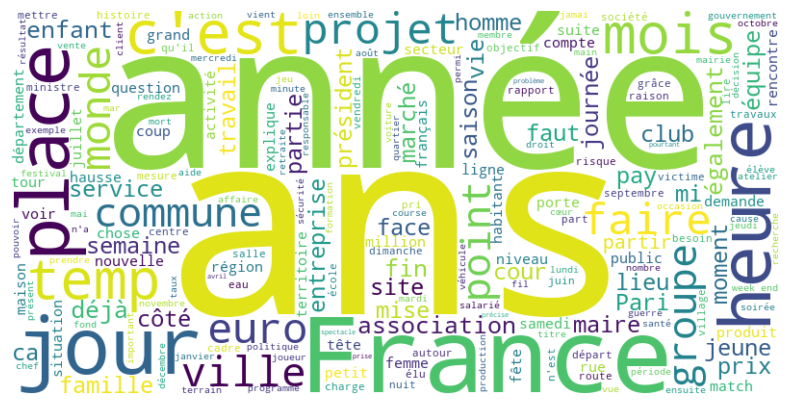

In [106]:
# concatenate all titles in a single string
titles = " ".join(df["title"].values)

wordcloud = WordCloud(width=800, height=400, 
                      background_color="white",
                      stopwords=STOPWORDS,
                      ).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text

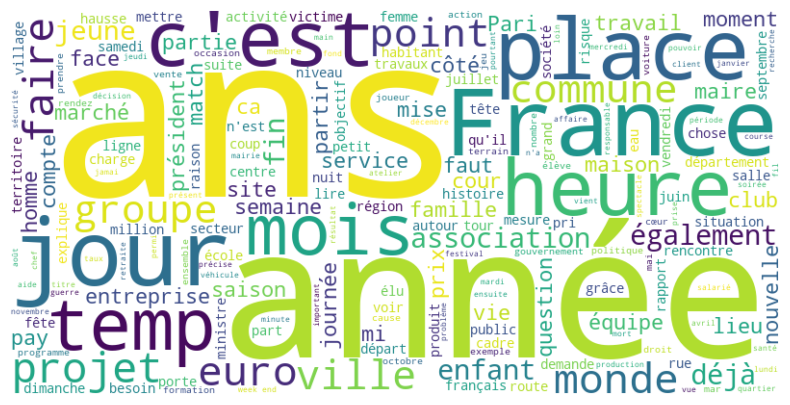

In [107]:
# find text with no restrictions (content_restrictions.isnull) and concatenate all the texts in a single string
text = " ".join(df[df["content_restrictions"].isnull()]["text"].values)

wordcloud = WordCloud(width=800, height=400, 
                      background_color="white",
                      stopwords=STOPWORDS,
                      ).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data analysis :

## Title / Text

    Unique words
    Html tags ?

## Text

    Looking at very long texts

## Date

    Min and max
    Distribution
    distribution per year/ month, day. (e.g Show which weekdays are the most popular)

## article
Show a graph aof content restrictions ed on articledomain
